**Datenset laden:** `torchvision.datasets.ImageFolder` ist genau für eigene Ordnerstrukturen wie deine (ein Ordner pro Klasse). Torchvision ist also nicht nur für CIFAR/ImageNet – du brauchst es für `ImageFolder`, `transforms` und später z.B. für Modell-Architekturen. Bei fehlendem Modul: `pip install torch torchvision`

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

img_size = (128, 128)

transform_valid = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_train = transforms.Compose([
    transforms.Resize(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 32

trainset = torchvision.datasets.ImageFolder(root='./chess_pieces/train', transform=transform_train)
validset = torchvision.datasets.ImageFolder(root='./chess_pieces/valid', transform=transform_valid)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)
validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size,
                                          shuffle=False, num_workers=0)

classes = trainset.classes
print("Klassen:", classes)

Klassen: ['black_bishop', 'black_king', 'black_knight', 'black_pawn', 'black_queen', 'black_rook', 'empty', 'white_bishop', 'white_king', 'white_knight', 'white_pawn', 'white_queen', 'white_rook']


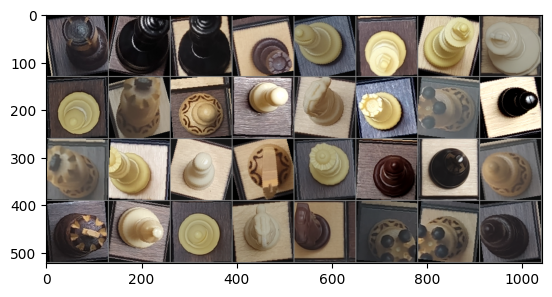

Labels: black_rook black_king black_king black_rook white_bishop white_king white_king white_king white_bishop white_king white_pawn white_pawn white_knight white_rook white_queen black_pawn white_king white_queen white_pawn white_knight white_queen black_bishop black_bishop white_bishop black_king white_bishop white_bishop white_knight black_knight white_queen white_queen black_bishop


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('Labels:', ' '.join(f'{classes[labels[j]]}' for j in range(batch_size)))

### Neuronales Netz

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.adapt = nn.AdaptiveAvgPool2d(5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 13)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.adapt(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### Optimizer und Loss-Function

In [22]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Training

In [ ]:
num_epochs = 15
net.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    n_batches = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        n_batches += 1
        if (i + 1) % 50 == 0:
            print(f'  epoch {epoch+1} batch {i+1}/{len(trainloader)} loss: {running_loss / n_batches:.3f}')
    print(f'[Epoch {epoch+1}/{num_epochs}] Ø train loss: {running_loss / len(trainloader):.3f}')
print('Finished Training')

  epoch 1 batch 50/74 loss: 2.565
[Epoch 1/15] Ø train loss: 2.565
  epoch 2 batch 50/74 loss: 2.562
[Epoch 2/15] Ø train loss: 2.562
  epoch 3 batch 50/74 loss: 2.560
[Epoch 3/15] Ø train loss: 2.559
  epoch 4 batch 50/74 loss: 2.557
[Epoch 4/15] Ø train loss: 2.557
  epoch 5 batch 50/74 loss: 2.555
[Epoch 5/15] Ø train loss: 2.554
  epoch 6 batch 50/74 loss: 2.552
[Epoch 6/15] Ø train loss: 2.551
  epoch 7 batch 50/74 loss: 2.546
[Epoch 7/15] Ø train loss: 2.546
  epoch 8 batch 50/74 loss: 2.538
[Epoch 8/15] Ø train loss: 2.537
  epoch 9 batch 50/74 loss: 2.519
[Epoch 9/15] Ø train loss: 2.515
  epoch 10 batch 50/74 loss: 2.470
[Epoch 10/15] Ø train loss: 2.456
  epoch 11 batch 50/74 loss: 2.370
[Epoch 11/15] Ø train loss: 2.349
  epoch 12 batch 50/74 loss: 2.194
[Epoch 12/15] Ø train loss: 2.164
  epoch 13 batch 50/74 loss: 2.039
[Epoch 13/15] Ø train loss: 2.020
  epoch 14 batch 50/74 loss: 1.955
[Epoch 14/15] Ø train loss: 1.945
  epoch 15 batch 50/74 loss: 1.908
[Epoch 15/15] Ø t

### Model speichern

In [24]:
PATH = './piece-rec.pth'
torch.save(net.state_dict(), PATH)

### Testen

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in validloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on validation set: {100 * correct / total:.1f}%')

Accuracy on validation set: 20.0%


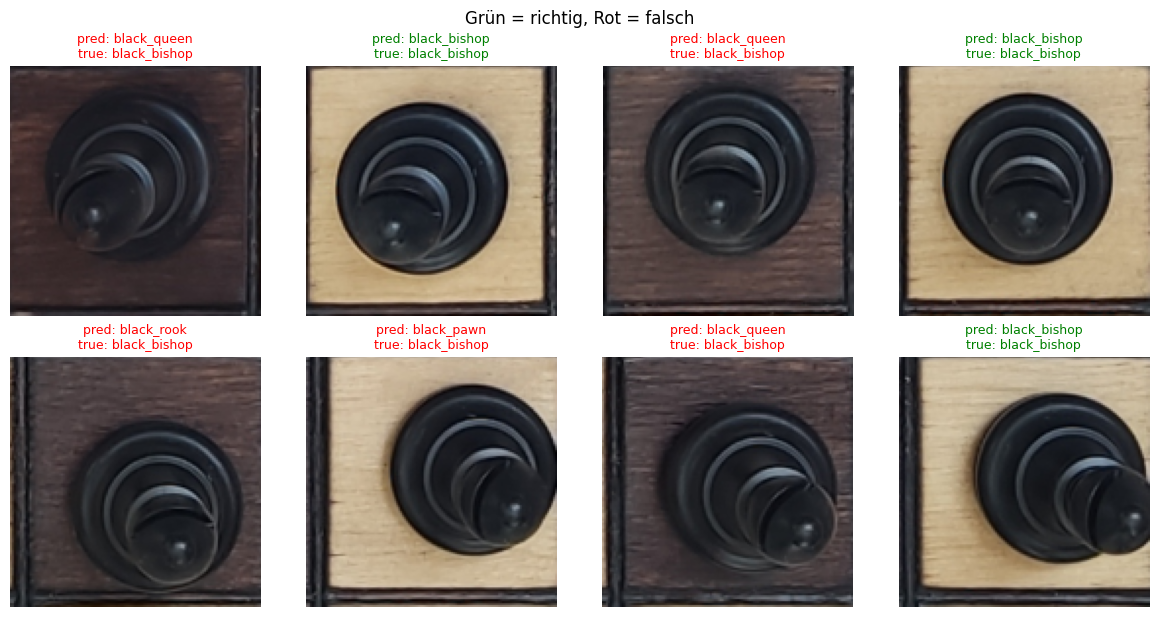

In [ ]:
import matplotlib.pyplot as plt

net.eval()
dataiter = iter(validloader)
images, labels = next(dataiter)

with torch.no_grad():
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)

n_show = min(8, images.size(0))
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()
for i in range(n_show):
    img = images[i] / 2 + 0.5
    img = img.numpy().transpose(1, 2, 0)
    axes[i].imshow(img)
    pred_str = classes[predicted[i].item()]
    true_str = classes[labels[i].item()]
    ok = predicted[i] == labels[i]
    axes[i].set_title(f'pred: {pred_str}\ntrue: {true_str}', fontsize=9, color='green' if ok else 'red')
    axes[i].axis('off')
for j in range(n_show, len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.suptitle('Grün = richtig, Rot = falsch', y=1.02)
plt.show()